# Filter for specific tidal frequencies

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import scipy.signal as sig
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [119]:
# import data

ds = xr.open_dataset(f'../../../Data/tide/tide.nc')
    
#print(ds)

In [121]:
# average data to 15-minute sampling

dsm = ds.coarsen(time=15,boundary='trim').mean()

In [74]:
# filter functions

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = sig.butter(order, [low,high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sig.sosfilt(sos, data)
    return y

<IPython.core.display.Javascript object>


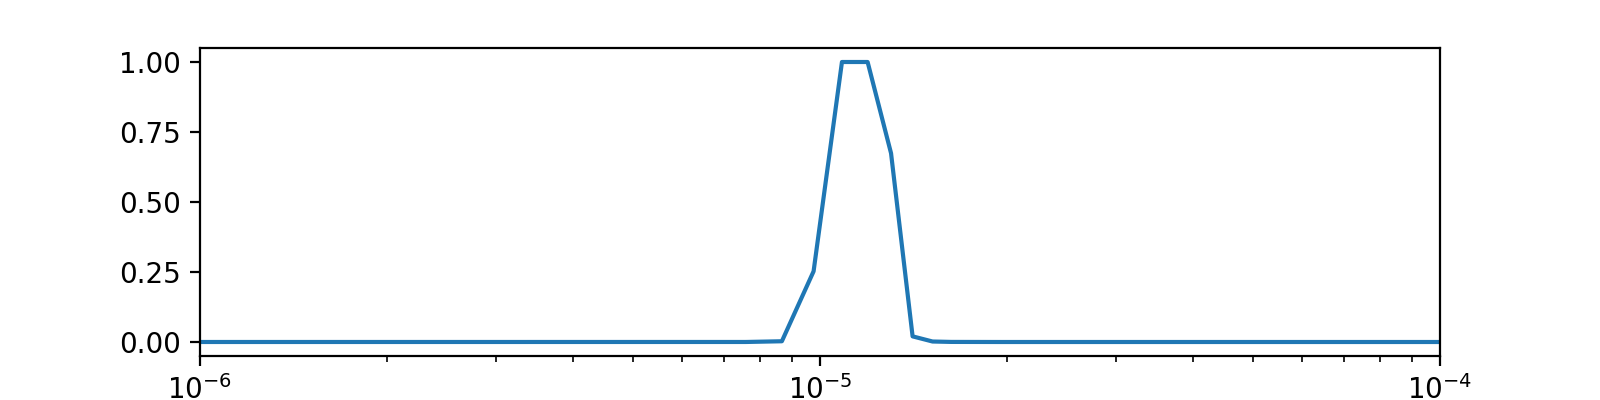

In [133]:
# filter to specific frequency range (diurnal)

fs = 1.111e-3                                    # samples /hour for entire time series
lowcut = 1.000e-5                                # filter cut-off
highcut = 1.300e-5                               # cut-off frequencies
order = 8

sos = butter_bandpass(lowcut,highcut,fs,order=order)   # digital butterworth filter
w, h = sig.sosfreqz(sos)                         # to plot filter response

# plot filter response

fig,ax = plt.subplots(1,1,figsize=(8,2))
ax.semilogx(w*(fs/2)/np.pi,abs(h))
ax.set_xlim(1e-6,1e-4)
plt.show()

<IPython.core.display.Javascript object>


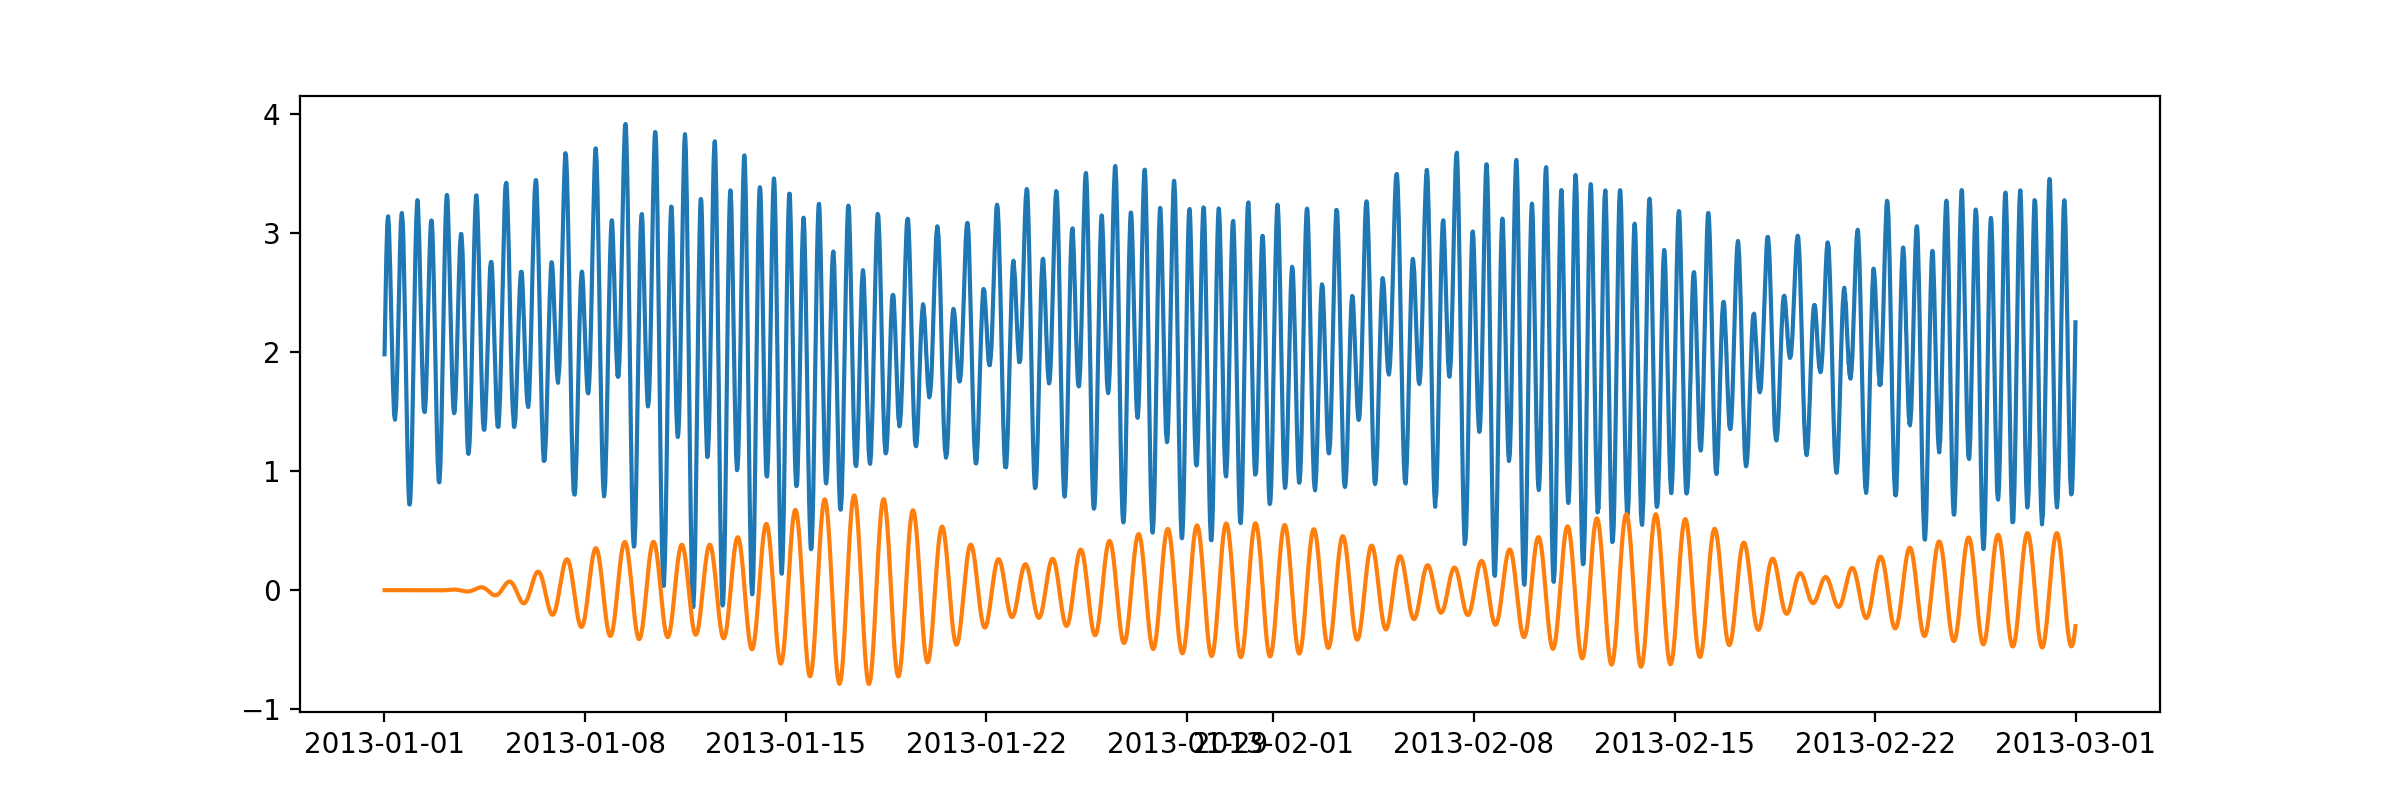

In [141]:
diurnal = butter_bandpass_filter(dsm.tide, lowcut, highcut, fs, order=order)       # apply low pass filter

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(dsm.time,dsm.tide)
ax.plot(dsm.time,diurnal)
plt.show()

In [142]:
# save to .nc file

# ds_out = xr.Dataset( 
#     data_vars=dict(
#         diurnal=(['time'], diurnal),    # tide height data [m]
#     ),
#     coords=dict(
#         time=dsm.time,              
#     ),
#     attrs=dict(
#         description=f'Tide data from Tofino CHS, filtered for diurnal response.',
#         units=['mean-removed metres amplitude, numpy.datetime64'],
#     ),
# ) 
# ds_out.to_netcdf(f'../../../Data/tide/diurnal_tide.nc')